Using Smopy means using OpenStreetMaps.  Per their usage rules: "Heavy use (e.g. distributing an app that uses tiles from openstreetmap.org) is forbidden without prior permission from the System Administrators. "

http://wiki.openstreetmap.org/wiki/Tile_usage_policy

In [1]:
import numpy as np
import networkx as nx
import json

#load the shapefile generated from an OSMnx pull (see v4.1 OSMnx to generate SHP.ipynb)
g = nx.read_shp('data/from_osmnx/edges/edges.shp')

#returns array of coordinates for any edge in the graph
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(g[n0][n1]['Json'])['coordinates'])

#returns in KILOMETERS
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

#Now, we define a function computing a path's length.
#This function has been found in StackOverflow. http://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance

#order of lats, lons was incorrect in tutorial! Corrected here
def get_path_length(path):
    return np.sum(geocalc(path[:-1,1], path[:-1,0], path[1:,1], path[1:,0]))

"""
    Shapefile is incomplete, so here we manually create edges known to exist
"""
#given two nodes, build a node between them
#nodes must be in (lon, lat) tuple
def create_edge(a,b):
    g.add_edge(a, b)
    g[a][b]['Json'] = '{ "type": "LineString" ,"coordinates" : [' + str([p for p in a]) + ', ' + str([p for p in b]) + ']}'


#road has a gate at the end of public part
p1 = (-122.38385529999999, 37.7423869)
p2 = (-122.382517, 37.741975)
create_edge(p1, p2) #lon/lat

#being directional means being unable to find edges unless in correct order
#so switch to unidirected
g = g.to_undirected()

sg_all = list(nx.connected_component_subgraphs(g.to_undirected()))

#grab the biggest subgraph
max_len = -1
sg_final = sg_all[0]
for sg in sg_all:
    x = len(sg)
    if x > max_len:
        max_len = x
        sg_final = sg
        
# establish all the nodes
nodes = np.array(sg_final.nodes())

#update graph by computing the distance between any two connected nodes
for n0, n1 in sg_final.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg_final.edge[n0][n1]['distance'] = distance
    
print('finished')    

finished


2014-01-13 00:00:00
2014-01-19 00:00:00
2014-07-15 00:00:00
2014-08-28 00:00:00
2014-12-16 00:00:00
2015-01-10 00:00:00
2015-03-28 00:00:00
2015-07-08 00:00:00
2016-01-06 00:00:00
2016-07-11 00:00:00
2016-08-15 00:00:00
2016-08-15 00:00:00
2016-11-15 00:00:00
2016-11-16 00:00:00
2016-11-24 00:00:00
2016-11-27 00:00:00
2016-11-29 00:00:00
2016-11-30 00:00:00
2016-12-15 00:00:00
2017-01-03 00:00:00
2017-01-08 00:00:00
2017-01-09 00:00:00
2017-01-30 00:00:00
2017-03-05 00:00:00
2017-03-07 00:00:00
2017-03-11 00:00:00
2017-03-11 00:00:00
2017-03-16 00:00:00
2017-03-20 00:00:00
2017-03-22 00:00:00
2017-03-23 00:00:00
2017-03-25 00:00:00
2017-03-26 00:00:00
2017-03-26 00:00:00
2017-03-28 00:00:00
2017-03-31 00:00:00
2017-04-03 00:00:00
2017-04-05 00:00:00
all runs mapped


# Map next running routes

In [2]:
import pandas as pd
import smopy  # for map display via openstreetmaps
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

#needed to convert csv of tuples from strings to tuples
from ast import literal_eval as make_tuple

In [3]:
#given a target edge, compile the total route and return its path & distance

def calc_route_option(my_start, my_end, my_target):
    #compile all waypoints
    my_route = [my_start]
    my_route.extend(my_target)
    my_route.extend([my_end])

    #send coordinates, receive path, add to master list
    my_path = build_path(my_route)

    #calc distance
    my_roads = pd.DataFrame([sg_final.edge[my_path[i]][my_path[i + 1]] 
                          for i in range(len(my_path) - 1)], 
                         columns=['distance', 'nhood', 'streetname'])
    
    # convert km -> mi
    my_distance = my_roads['distance'].sum() * 0.621371
    
    return my_path, my_distance

"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Concatenates the positions along every edge in the path. 
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    
    #if path is just one point, return that point
    if len(path) == 1:
        return path
    
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

#build a route between two points
def build_segment(a,b):
    segment = nx.shortest_path(sg_final, 
                        source=tuple(nodes[a]), 
                        target=tuple(nodes[b]),
                        weight='distance')
    return segment[1:]

#given a list of waypoints (not specifically edge-coordinates), return a path

def build_path(waypoints):
    #convert waypoints to node indexes
    #just finds the closest node ==> should upgrade and find the closest coordinate!
    waypoint_nodes = [np.argmin(np.sum((nodes[:,::-1] - w)**2, axis=1)) for w in waypoints]
    
    #seed with first node
    my_path = [tuple(nodes[waypoint_nodes[0]])]
    
    #iterate thru all but last, connecting this to next
    for i in range(len(waypoints)-1):
        my_path.extend(build_segment(waypoint_nodes[i], waypoint_nodes[i+1]))
        
    return my_path

print('finished')

finished


In [4]:
"""
    Part 2: visualizing
"""
#plot nodes, a function sometimes called in plt_edge
def plt_node(a,b, color='black', size=1):
    
    for x,y in zip(a,b):
        ax.plot(x,y, 'o', color=color, ms=size, markeredgewidth=0.0)
        
#given a path and color, plot it.  Optional: plot nodes, adjust width
def plt_edge(mini_path, color, plot_nodes=False, width=0.5):
    mini_linepath = get_full_path(mini_path)
    mx, my = map.to_pixels(mini_linepath[:,1], mini_linepath[:,0])
    ax.plot(mx, my, '-k', lw=width, color=color, alpha=0.5)
    if plot_nodes:
        plt_node(mx, my)


Load in unexplored data, use this to generate target edges to explore route possibilities

In [5]:
#given a random point and the path, what is the lower-left and upper-right map points

def find_corners(point, my_paths):
    #this finds the lowest & highest lat/lon even if not directly paired
    ll_lat = point[0]
    ll_lon = point[1]
    ur_lat = point[0]
    ur_lon = point[1]

    for mp in my_paths:
        for p in mp:
            if p[1] < ll_lat:
                ll_lat = p[1]
            if p[0] < ll_lon:
                ll_lon = p[0]
            if p[1] > ur_lat:
                ur_lat = p[1]
            if p[0] > ur_lon:
                ur_lon = p[0]

    return (ll_lat, ll_lon), (ur_lat, ur_lon)

print('finished')

finished


In [9]:
'''Set user-input params'''

'Set user-input params'

51 paths
2.88 mi
[(37.802056, -122.423589), (37.801861, -122.424581)]
2.95 mi
[(37.77904, -122.403895), (37.779786, -122.402919)]
2.87 mi
[(37.788877, -122.399895), (37.790202, -122.398253)]
Lowered zoom level to keep map size reasonable. (z = 14)


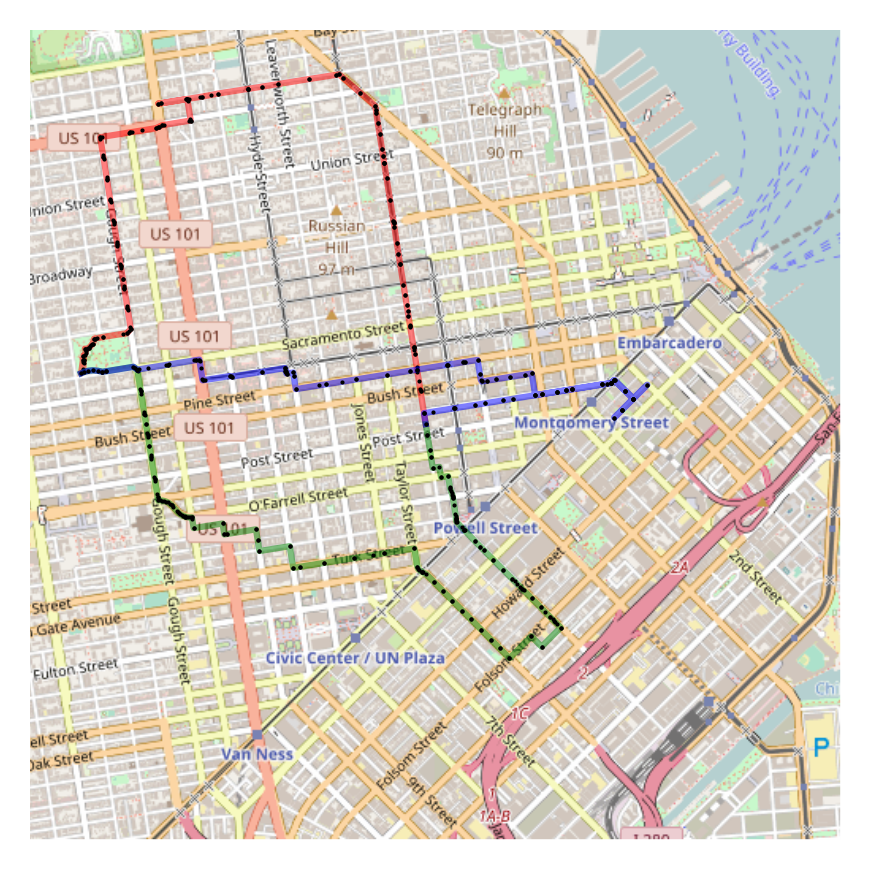

In [6]:
#define a goal distance    
goal_distance = 2.91

#build up color list
colors = ['red', 'green', 'blue']

#notable spots
home = (37.790461, -122.428311)
work = (37.789006, -122.409448)
gym = (37.788585, -122.410184)

## define the key areas of the route
start = home
end = gym

#load data
df = pd.read_csv('unexplored blocks.csv', sep='\t')

#for some reason, I have to explicitly state the columns or it bugs out
df.columns = ['start', 'end']

#iterate through csv of unrun blocks, compiling into an array of edges
targets = []

for index, row in df.iterrows():
    this_target = [make_tuple(row['start']), make_tuple(row['end'])]
    targets.append(this_target)
    
#for each set of targets, iterate through and build a route, calculate the distance and store in a list of routes
paths = [] 
path_distances = []

for ti in range(len(targets)):
    p,d = calc_route_option(start, end, targets[ti])
    paths.append(p)
    path_distances.append(d)

print(str(len(paths)) + ' paths')

#rescore distances based on "closeness" to goal distance
distances_from_goal = [abs(i - goal_distance) for i in path_distances]

#pick closest three paths
best_paths_i = np.argsort(distances_from_goal)[:3]
best_paths = [paths[i] for i in best_paths_i]

#distances of closest three routes
for i in best_paths_i:
    print(str(round(path_distances[i],2)) + ' mi')
    print(targets[i])
    
#display the top 3 itineraries on the map

path_ll, path_ur = find_corners(start, best_paths)

map = smopy.Map(path_ll, path_ur)

ax = map.show_mpl(figsize=(3,3))

for p_i in range(len(best_paths)):
    plt_edge(best_paths[p_i], colors[p_i], True, width=1.5)


guessing edge for (37.757806, -122.39608500000001)
guessing edge for (37.753904, -122.399197)
guessing edge for (37.753828, -122.398891)
guessing edge for (37.753777, -122.39833799999998)
guessing edge for (37.753895, -122.398236)
guessing edge for (37.753984, -122.398065)
guessing edge for (37.754035, -122.39782300000002)
guessing edge for (37.753959, -122.397528)
guessing edge for (37.753836, -122.39736700000002)
guessing edge for (37.752924, -122.396525)
guessing edge for (37.752754, -122.39645)
guessing edge for (37.752623, -122.39646600000002)
guessing edge for (37.751499, -122.396396)
guessing edge for (37.750574, -122.39630499999998)
guessing edge for (37.747414000000006, -122.39613899999999)
guessing edge for (37.744937, -122.39179400000002)
guessing edge for (37.741747, -122.385936)
guessing edge for (37.741722, -122.384026)
guessing edge for (37.742129000000006, -122.383897)
guessing edge for (37.742282, -122.38330699999999)
guessing edge for (37.742146, -122.38288900000002)


51 paths
6.66 mi
[(37.786751, -122.476628), (37.786183, -122.476585)]
7.35 mi
[(37.778419, -122.47936), (37.778377, -122.48025)]
5.69 mi
[(37.759133, -122.440143), (37.759294, -122.441752)]
Lowered zoom level to keep map size reasonable. (z = 14)


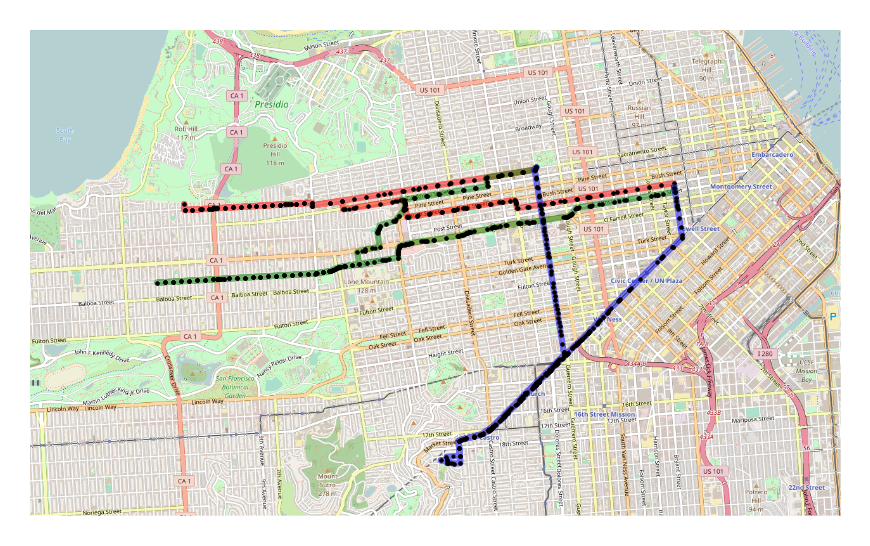

### Load run history > map a KML > Add a missing edge

guessing edge for (37.781756, -122.444561)
plotted to v5 test_markers.html


51 paths
2.99 mi
[(37.77904, -122.403895), (37.779786, -122.402919)]
2.98 mi
[(37.78903, -122.396539), (37.789573, -122.395809)]
3.14 mi
[(37.788004, -122.395637), (37.786461, -122.397622)]
Lowered zoom level to keep map size reasonable. (z = 15)


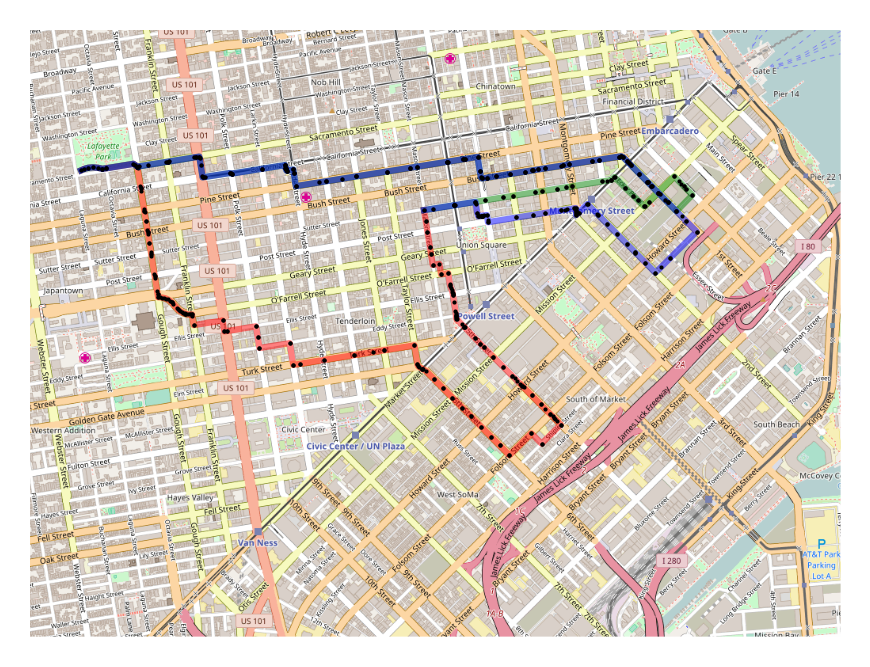

In [17]:
len(soup.find_all('placemark'))

446

In [4]:
#given a point, plot the closest node and its neighbors
#my_point must be a (lat, lon) tuple
def neighbor_nodes(my_point):
    
    my_map = gmplot.GoogleMapPlotter(my_point[0], my_point[1], 16)
    my_map.scatter([my_point[0]], [my_point[1]], marker=False, size=15, color='black')
    print('black', 'point')

    my_nodes = find_closest_node(my_point, 6)

    my_colors = ['red', 'orange', 'blue', 'green', 'purple', 'grey']
    i = 0
    for n in my_nodes:
        print(my_colors[i], n)
        my_map.scatter([n[1]], [n[0]], marker=False, size=10, color=my_colors[i])
        i+=1
        
    my_map_file = 'v5 - plot surrounding nodes.html'
    my_map.draw(my_map_file)        
    print('mapped to ' + my_map_file)

In [44]:
a_point = a_run_coords[12]
a_point = coord_to_node(a_point)
neighbor_nodes(a_point)

black point
red (-122.4752673, 37.7898815)
orange (-122.47464859999999, 37.788529199999999)
blue (-122.47464720000001, 37.788511300000003)
green (-122.4756476, 37.788861500000003)
purple (-122.47464309999999, 37.788457800000003)
grey (-122.4751699, 37.788429899999997)
mapped to v5 - plot surrounding nodes.html


In [45]:
ce = find_closest_edge(a_point, 'all')
a_map = gmplot.GoogleMapPlotter.from_geocode("San Francisco")
plot_edge_gmap(ce[0], ce[1], color='purple', nodes=False)
a_map.draw('v5 - close edges.html')        

In [38]:
dist_nodes = np.sum((nodes[:,::-1] - a_point)**2, axis=1)
dist = min(dist_nodes**0.5)
print(dist, 50 / 100000)

0.000484799608086 0.0005


#### Load run history > map a KML > Add a missing edge > Fill in Presidio graph

Lowered zoom level to keep map size reasonable. (z = 15)


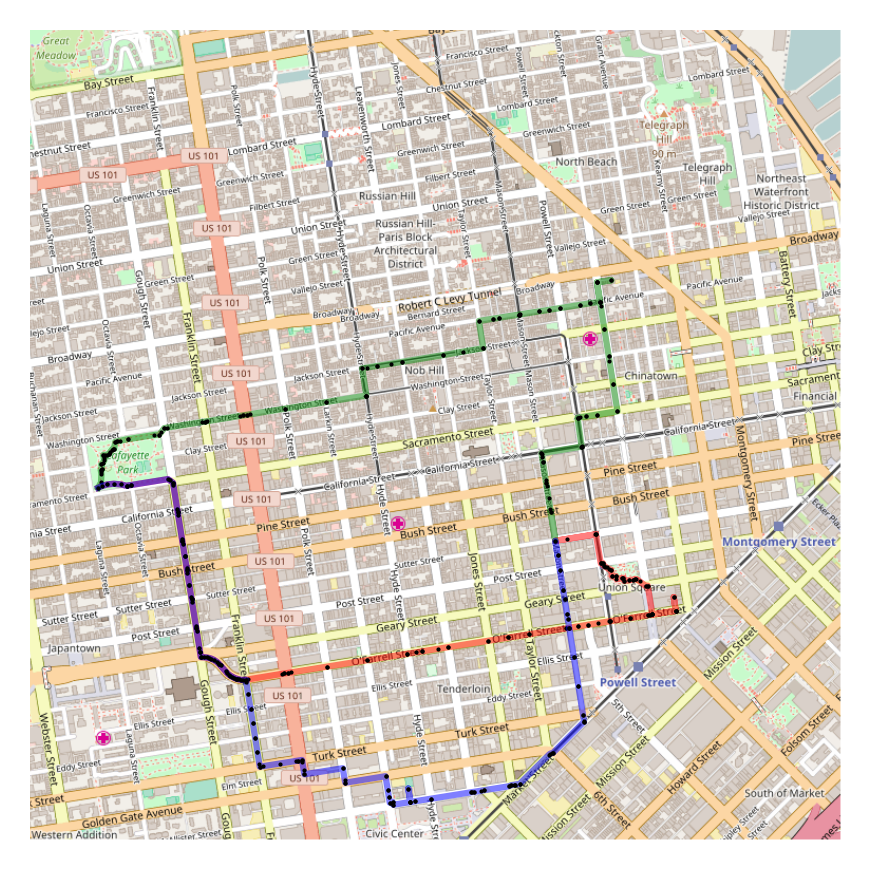

In [25]:
g_2 = nx.read_shp('Road files/data/tl_2016_06075_roads.shp')

In [26]:
#loop through second graph's nodes and get the closest node's distance from first graph
#if distance < threshold => exclude

#intialize threshold, lists
threshold = 50 / 100000
a_lats = []
a_lons = []

b_lats = []
b_lons = []

#loop through and pluck any nodes not included in original
for n in g_2.nodes_iter():
    closest_node, closest_distance = find_closest_node(n[::-1], distance=True)
    
    if closest_distance > threshold:
        a_lats.append(n[1])
        a_lons.append(n[0])

for n in g.nodes_iter():
    b_lats.append(n[1])
    b_lons.append(n[0])
  
#plot
a_map = gmplot.GoogleMapPlotter.from_geocode("San Francisco")
    
#g_2 shadow
a_map.scatter(a_lats, a_lons, size=15, marker=False, color='red')

#g
a_map.scatter(b_lats, b_lons, size=10, marker=False, color='blue')
    
a_map.draw('v5 other graph.html')

446

black point
red (-122.44464929999999, 37.781066600000003)
orange (-122.4438512, 37.781873500000003)
blue (-122.44388840000001, 37.781367400000001)
green (-122.44377249999999, 37.781885899999999)
purple (-122.44444559999999, 37.782569500000001)
grey (-122.4436852, 37.781406799999999)
mapped to v5 - plot surrounding nodes.html


# scratch

In [23]:
#diagnosing
a_point = a_run_coords[9]
a_node = coord_to_node(a_point)
neighbor_nodes(a_node)
print(a_point)
print(a_node)

black point
red (-122.44464929999999, 37.781066600000003)
orange (-122.4438512, 37.781873500000003)
blue (-122.44388840000001, 37.781367400000001)
green (-122.44377249999999, 37.781885899999999)
purple (-122.44444559999999, 37.782569500000001)
grey (-122.4436852, 37.781406799999999)
mapped to v5 - plot surrounding nodes.html
-122.444561,37.781756,0.0
(37.781756, -122.444561)


In [43]:
#given a KML run, plot it on google maps
#inferring closest nodes, edges
#def plot_kml(my_coords):

threshold = 50 / 100000000
print('starting with ' + str(a_point))

#take apart the individual points
this_coord = a_point.split(',')
lat = float(this_coord[1])
lon = float(this_coord[0])
this_point = (lat, lon)
    
print('converted to ' + str(this_point))

#if distance is < threshold, then just use the closest node.  Else, find the closest edge.  And plot it 

# need to incorporate coordinates within the edge?

dist_nodes = np.sum((nodes[:,::-1] - this_point)**2, axis=1)
dist = min(dist_nodes**0.5)
print('closest node is ' + str(dist) + ' vs threshold of ' + str(threshold))

if dist < threshold:
    print('dist < threshold')

    my_color = 'blue'
else:
    print('dist > threshold')
    print('guessing edge for ' + str(this_point))
    ce = find_closest_edge(this_point, 'all')
    print(ce)
    my_color = 'red'

starting with -122.444561,37.781756,0.0
converted to (37.781756, -122.444561)
closest node is 0.000695031833802 vs threshold of 5e-07
dist > threshold
guessing edge for (37.781756, -122.444561)
[(-122.4455349, 37.7813317), (-122.4438512, 37.7818735)]


In [25]:
edge_points, edge_distance = find_closest_edge(this_point, 'all', True)

In [26]:
dist < edge_distance

True

In [27]:
edge_points

[(-122.4455349, 37.7813317), (-122.4438512, 37.7818735)]

In [34]:
a_map = gmplot.GoogleMapPlotter(edge_points[0][1], edge_points[0][0], 14)
plot_edge_gmap(edge_points[0], edge_points[1], nodes=True)
a_map.draw('v5 closest edge.html')

In [38]:
coord_dist = distance_from_edge_coord(edge_points[0], edge_points[1], this_point)

In [39]:
line_dist = distance_from_line(edge_points[0][::-1], edge_points[1][::-1], this_point)

In [40]:
coord_dist < line_dist

True

In [41]:
coord_dist

8.1085757067436167e-05

In [44]:
dist

0.00069503183380236887